In [2]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import os

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
import json 
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from itertools import product
import ast
import math
from sklearn.cluster import KMeans
import time
from datetime import datetime

In [3]:
data=pd.read_csv('./beijing_2019-06-19_20_47_all_features.csv')

In [4]:
len(data)

594358

<Figure size 5760x5760 with 0 Axes>

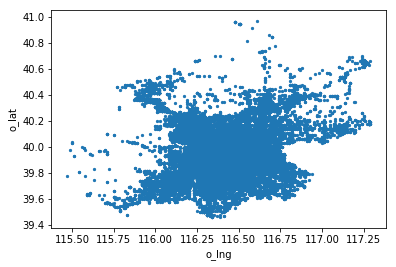

In [5]:
plt.figure(figsize=(80, 80))
data.plot.scatter(x='o_lng', y='o_lat',marker='.')

In [6]:
np.min(data['o_lng'])

115.47

In [7]:
np.max(data['o_lng'])

117.29

In [8]:
np.min(data['o_lat'])

39.46

In [9]:
np.max(data['o_lat'])

40.97

# 数据处理

# 特征工程

####  加上外部地点特征

In [3]:
address_all_info_final=pd.read_csv('./address_all_info_final.csv')

address_all_info_final=address_all_info_final.drop(['Unnamed: 0','address_lng','address_lat'],axis=1)

address_all_info_final_o=address_all_info_final.rename(columns={'address':'o'})
data = data.merge(address_all_info_final_o, on=['o'], how='left')

address_all_info_final_d=address_all_info_final.rename(columns={'address':'d','Subway_number_list':'Subway_number_list1','Bus_number_list':'Bus_number_list1','University_number_list':'University_number_list1','Middle_School_number_list':'Middle_School_number_list1'})
data = data.merge(address_all_info_final_d, on=['d'], how='left')

# 模型训练及预测

In [9]:
######################################   特征加载    ######################################
print('特征加载')
######################################   非特征    ######################################
or_feature  = ['req_time','click_mode','sid']

######################################   原始特征    ######################################
cate_feature = ['pid'] 
profile_feature = ['p' + str(i) for i in range(66)]

origin_num_feature = ['o_lng', 'o_lat', 'd_lng', 'd_lat'] + profile_feature + cate_feature
                     
########################################  经纬度特征  ##########################################
od_feature = ['od_manhattan_distance', 'od_manhattan_distance_detail', 'o_main_centroid_mean_dis', 'd_main_centroid_mean_dis', 'o_main_centroid_mode_dis', 'd_main_centroid_mode_dis', 'o_cluster', 'd_cluster']

########################################  距离特征  ##########################################
distance_feature = ['manhattan','euclidean','delta_longitude','delta_latitude','pickup_x','pickup_y','pickup_z','dropoff_x','dropoff_y','dropoff_z','direction']

################################  plan_time & req_time特征  ###################################
#所有时间特征
all_time_feature = ['req_time_hour', 'req_time_weekday', 'req_time_minute', 'req_time_date_d', 'time_diff', 
                'diff_6_cloc', 'diff_12_clock', 'diff_18_clock', 'diff_24_clock']
#选择的时间特征
time_feature=['req_time_hour', 'time_diff', 'diff_6_cloc', 'diff_12_clock', 'diff_18_clock', 'diff_24_clock']


################################  对profile的降维提取特征  ###################################
#所有特征
all_profiles_svd_feature = ['svd_fea_{}'.format(i) for i in range(10)]
#选择特征
profiles_svd_feature = []


##############################  plans百度地图推荐交通方式特征  #################################
plan_feature = ['mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode_feas_4', 'mode_feas_5', 'mode_feas_6', 'mode_feas_7', 'mode_feas_8', 'mode_feas_9', 'mode_feas_10', 'mode_feas_11', 
               'max_dist', 'min_dist', 'mean_dist', 'std_dist', 'max_price', 'min_price', 'mean_price', 'std_price', 'max_eta', 'min_eta', 'mean_eta', 'std_eta', 'max_dist_mode', 'min_dist_mode', 'max_price_mode', 'min_price_mode', 'max_eta_mode', 'min_eta_mode', 
               'first_mode', 'svd_mode_0', 'svd_mode_1', 'svd_mode_2', 'svd_mode_3', 'svd_mode_4', 'svd_mode_5', 'svd_mode_6', 'svd_mode_7', 'svd_mode_8', 'svd_mode_9']

##############################  plan推荐mode平铺特征  #################################
pingpu_dist_feature=['plan_model_'+str(i)+'_dist'  for i in range(1,12)]
pingpu_price_feature=['plan_model_'+str(i)+'_price'  for i in range(1,12)]
pingpu_eta_feature=['plan_model_'+str(i)+'_eta'  for i in range(1,12)]
pingpu_rank_feature=['plan_model_'+str(i)+'_rank'  for i in range(1,12)]
#所有特征
all_plan_pingpu_feature = pingpu_dist_feature+pingpu_price_feature+pingpu_eta_feature+pingpu_rank_feature
#选择特征
plan_pingpu_feature = pingpu_dist_feature+pingpu_price_feature+pingpu_rank_feature

##############################  位置点和od对出现次数及排序特征  #################################
#所有特征
all_od_appear_feature = ['o_appear_count','d_appear_count','o_appear_count_rank','d_appear_count_rank','o_appear_count_rank_buguiyi','d_appear_count_rank_buguiyi',
                     'od_couple','od_couple_count','od_couple_rank','od_couple_rank_buguiyi']
#选择特征
od_appear_feature = ['o_appear_count','d_appear_count','o_appear_count_rank','d_appear_count_rank','o_appear_count_rank_buguiyi','d_appear_count_rank_buguiyi',
                     'od_couple_count']

#########################  对plan_mode中的dis、eta、price和rank进行排序特征  ###########################
pingzhan_dist_rank_feature=['plan_model_'+str(i)+'_dist_rank'  for i in range(1,12)]
pingzhan_price_rank_feature=['plan_model_'+str(i)+'_price_rank'  for i in range(1,12)]
pingzhan_eta_rank_feature=['plan_model_'+str(i)+'_eta_rank'  for i in range(1,12)]
pingzhan_rank_rank_feature=['plan_model_'+str(i)+'_rank_rank'  for i in range(1,12)]

pingzhan_dist_rank_guiyi_feature=['plan_model_'+str(i)+'_dist'+'_rank_guiyi'  for i in range(1,12)]
pingzhan_price_rank_guiyi_feature=['plan_model_'+str(i)+'_eta'+'_rank_guiyi'  for i in range(1,12)]
pingzhan_eta_rank_guiyi_feature=['plan_model_'+str(i)+'_price'+'_rank_guiyi'  for i in range(1,12)]
pingzhan_rank_rank_guiyi_feature=['plan_model_'+str(i)+'_rank'+'_rank_guiyi'  for i in range(1,12)]
#所有特征
all_plan_pingzhan_rank_feature=pingzhan_dist_rank_feature+pingzhan_price_rank_feature+pingzhan_eta_rank_feature+pingzhan_rank_rank_feature+pingzhan_dist_rank_guiyi_feature+pingzhan_price_rank_guiyi_feature+pingzhan_eta_rank_guiyi_feature+pingzhan_rank_rank_guiyi_feature
#选择特征
plan_pingzhan_rank_feature=pingzhan_dist_rank_feature+pingzhan_price_rank_feature+pingzhan_eta_rank_feature+pingzhan_rank_rank_feature

##########################################  咕噜提分特征  #############################################
add_feature = ['pid' + '_mode_' + str(i) for i in range(1,12)] 

##########################################  协同特征  #############################################
xietong_feature = ['sloc_count', 'eloc_as_sloc_count', 'sloc_as_eloc_count',
       'eloc_count', 'user_eloc_as_sloc_count', 'user_sloc_as_eloc_count',
        'user_sloc_count',
       'sloc_eloc_common_eloc_count', 'sloc_eloc_common_sloc_count',
       'sloc_eloc_common_conn1_count', 'sloc_eloc_common_conn2_count',
       'sloc_eloc_common_eloc_rate', 'sloc_eloc_common_sloc_rate',
       'sloc_eloc_common_conn1_rate', 'sloc_eloc_common_conn2_rate',
       'user_sloc_eloc_common_eloc_count',
       'user_sloc_eloc_common_sloc_count',
       'user_sloc_eloc_common_conn1_count',
       'user_sloc_eloc_common_conn2_count',
       'user_sloc_eloc_common_eloc_rate',
       'user_sloc_eloc_common_sloc_rate',
       'user_sloc_eloc_common_conn1_rate',
       'user_sloc_eloc_common_conn2_rate']

##########################################  地铁特征  #############################################            
subway_feature = ['o_d_dis2subway','o_nearest_subway_dis', 'd_nearest_subway_dis', 'o_d_dis2subway1','odis2subway','ddis2subway']  

##########################################  公交特征  #############################################           
bus_feature = ['o_d_dis2bus', 'o_nearest_bus_dis', 'd_nearest_bus_dis', 'o_d_dis2bus1','odis2bus','ddis2bus']  
##########################################  大学特征  #############################################
school_feature = ['od_s']

##########################################  天气特征  #############################################
weather_feature = ['precipType','summary','temperature','uvIndex','visibility','windBearing','windSpeed']


print('特征加载完成')
#保存选择的特征
Select_features = or_feature + origin_num_feature + od_feature + distance_feature + time_feature + profiles_svd_feature + plan_feature + plan_pingpu_feature + od_appear_feature + plan_pingzhan_rank_feature + add_feature + xietong_feature + subway_feature + bus_feature + school_feature + weather_feature
#删除一部分  低重要度
Select_features.remove('plan_model_6_price_rank')
Select_features.remove('plan_model_5_price_rank')
Select_features.remove('plan_model_5_price')
Select_features.remove('plan_model_6_price')
Select_features.remove('plan_model_3_price_rank')
Select_features.remove('plan_model_3_price')

Select_features.remove('plan_model_9_rank_rank')
Select_features.remove('plan_model_6_rank_rank')
Select_features.remove('plan_model_5_rank_rank')
Select_features.remove('plan_model_8_rank_rank')
Select_features.remove('plan_model_10_rank_rank')
Select_features.remove('plan_model_11_rank_rank')
filename="beijing_{:%Y-%m-%d_%H_%M}_Select_features.csv".format(datetime.now())



特征加载
特征加载完成


In [10]:
# exter_2=['Subway_number_list',
#        'Bus_number_list', 'University_number_list',
#        'Middle_School_number_list', 'Subway_number_list1',
#        'Bus_number_list1', 'University_number_list1',
#        'Middle_School_number_list1']

In [11]:
#%%
#使用的特征
add_feature = ['pid' + '_mode_' + str(i) for i in range(1,12)] 
feature = [col for col in Select_features if col not in ['req_time','click_mode','sid', 'pid']]
feature =[col for col in feature if col not in add_feature ]
#模型训练&验证s
#评估指标设计
def f1_weighted(labels,preds):
    preds = np.argmax(preds.reshape(12, -1), axis=0)
    score = f1_score(y_true=labels, y_pred=preds, average='weighted')
    return 'f1_weighted', score, True

def pred_proba(proba):
    res = []
#    pred_proba.tolist()
    for i, e in enumerate(proba):
        if e[3] >= 0.180:
            e[3] = 1
        if e[4] >= 0.118:
            e[4] = 1
        if e[6] >= 0.217:
            e[6] = 1
        if e[8] >= 0.21:
            e[8] = 1
        if e[9] >= 0.36:
            e[9] = 1
        if e[10] >= 0.285:
            e[10]=1
        if e[11] >= 0.34:
            e[11]=1
        res.append(e)
    df = pd.DataFrame(res)
    pred = df.idxmax(axis = 1)
    return pred

train_index = (data.req_time < '2018-11-23') 
train_x     = data[train_index][feature].reset_index(drop=True)
train_y     = data[train_index].click_mode.reset_index(drop=True)

valid_index = (data.req_time > '2018-11-23') & (data.req_time < '2018-12-01')
valid_x     = data[valid_index][feature].reset_index(drop=True)
valid_y     = data[valid_index].click_mode.reset_index(drop=True)

test_index = (data.req_time > '2018-12-01')
test_x     = data[test_index][feature].reset_index(drop=True)

print(len(feature), feature)
#lgb_model = lgb.LGBMClassifier(boosting_type="gbdt", num_leaves=61, reg_alpha=0, reg_lambda=0.01,
#    max_depth=-1, n_estimators=2000, objective='multiclass',
#    subsample=0.8, colsample_bytree=0.8, subsample_freq=1,min_child_samples = 50,  learning_rate=0.05, random_state=2019, metric="None",n_jobs=-1)
lgb_model = lgb.LGBMClassifier(boosting_type="gbdt", num_leaves=61, reg_alpha=0, reg_lambda=0.01,
    max_depth=-1, n_estimators=2000, objective='multiclass',
    subsample=0.8, colsample_bytree=0.8, subsample_freq=1,min_child_samples = 50,  learning_rate=0.01, random_state=2019, metric="None",n_jobs=-1)

eval_set = [(valid_x, valid_y)]
lgb_model.fit(train_x, train_y, eval_set=eval_set, eval_metric=f1_weighted, verbose=10, early_stopping_rounds=100)


251 ['o_lng', 'o_lat', 'd_lng', 'd_lat', 'p0', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36', 'p37', 'p38', 'p39', 'p40', 'p41', 'p42', 'p43', 'p44', 'p45', 'p46', 'p47', 'p48', 'p49', 'p50', 'p51', 'p52', 'p53', 'p54', 'p55', 'p56', 'p57', 'p58', 'p59', 'p60', 'p61', 'p62', 'p63', 'p64', 'p65', 'od_manhattan_distance', 'od_manhattan_distance_detail', 'o_main_centroid_mean_dis', 'd_main_centroid_mean_dis', 'o_main_centroid_mode_dis', 'd_main_centroid_mode_dis', 'o_cluster', 'd_cluster', 'manhattan', 'euclidean', 'delta_longitude', 'delta_latitude', 'pickup_x', 'pickup_y', 'pickup_z', 'dropoff_x', 'dropoff_y', 'dropoff_z', 'direction', 'req_time_hour', 'time_diff', 'diff_6_cloc', 'diff_12_clock', 'diff_18_clock', 'diff_24_clock', 'mode_feas_0', 'mode_feas_1', 'mode_feas_2', 'mode_feas_3', 'mode

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.8,
        importance_type='split', learning_rate=0.01, max_depth=-1,
        metric='None', min_child_samples=50, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=2000, n_jobs=-1, num_leaves=61,
        objective='multiclass', random_state=2019, reg_alpha=0,
        reg_lambda=0.01, silent=True, subsample=0.8,
        subsample_for_bin=200000, subsample_freq=1)

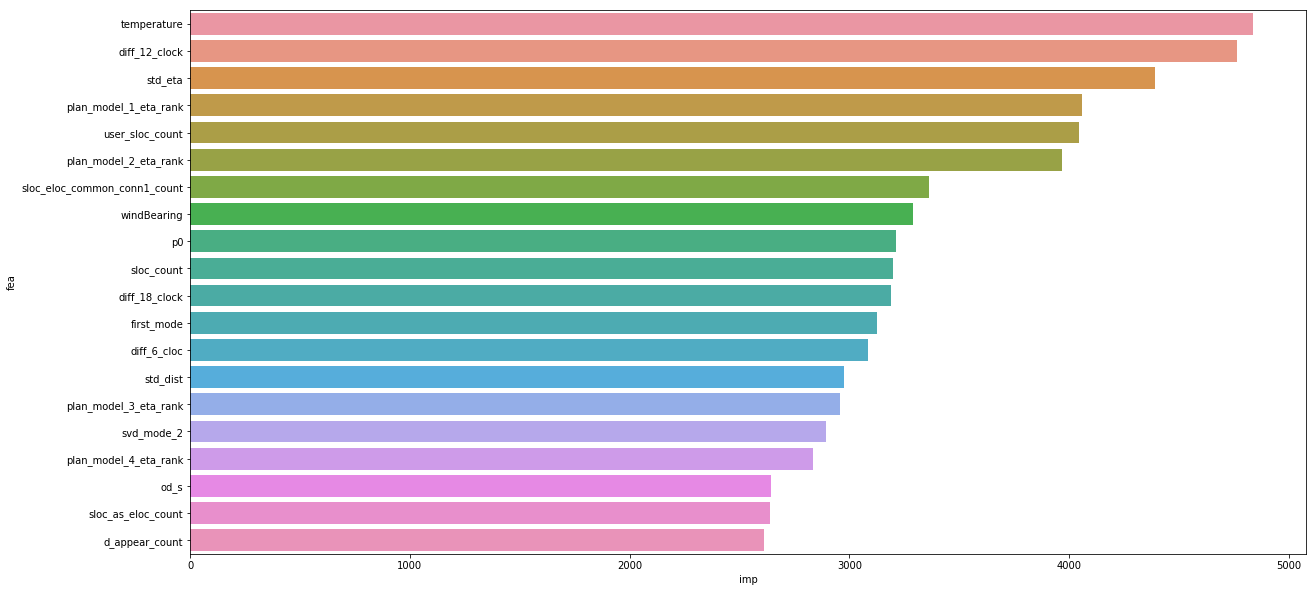

In [7]:

#特征重要性分析
imp = pd.DataFrame()
imp['fea'] = feature
imp['imp'] = lgb_model.feature_importances_ 
imp = imp.sort_values('imp',ascending = False)
imp
plt.figure(figsize=[20,10])
sns.barplot(x = 'imp', y ='fea',data = imp.head(20))


In [12]:
#预测结果分析
proba = lgb_model.predict_proba(valid_x)
pred = pred_proba(proba)
score=f1_score(valid_y, pred, average='weighted')
print('offline_f1_score:', score)
df_analysis = pd.DataFrame()
df_analysis['sid']   = data[valid_index]['sid']
df_analysis['label'] = valid_y.values
df_analysis['pred']  = pred
df_analysis['label'] = df_analysis['label'].astype(int)

score_df = pd.DataFrame(
    columns=['class_id', 'counts*f1_score', 'f1_score', 'precision', 'recall'])

from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score,recall_score,precision_score
dic_ = df_analysis['label'].value_counts(normalize = True)
def get_weighted_fscore(y_pred, y_true):
    f_score = 0
    for i in range(12):
        yt = y_true == i
        yp = y_pred == i
        f_score += dic_[i] * f1_score(y_true=yt, y_pred= yp)
        score_df.loc[i] = i,dic_[i],f1_score(y_true=yt, y_pred= yp), precision_score(y_true=yt, y_pred= yp),recall_score(y_true=yt, y_pred= yp)
    print('f_score:', f_score)
    return score_df
score_df = get_weighted_fscore(y_true =df_analysis['label'] , y_pred = df_analysis['pred'])
print(score_df)

offline_f1_score: 0.697787237964713
f_score: 0.03553080004506403
    class_id  counts*f1_score  f1_score  precision    recall
0        0.0         0.087414  0.003533   0.083333  0.001805
1        1.0         0.144617  0.028020   0.137500  0.015599
2        2.0         0.313324  0.066155   0.322609  0.036856
3        3.0         0.044598  0.003315   0.026316  0.001769
4        4.0         0.024453  0.007026   0.037975  0.003871
5        5.0         0.097574  0.019367   0.091281  0.010833
6        6.0         0.019893  0.003046   0.038462  0.001586
7        7.0         0.177920  0.041250   0.183860  0.023231
8        8.0         0.004559  0.000000   0.000000  0.000000
9        9.0         0.049931  0.012832   0.083333  0.006951
10      10.0         0.028475  0.006747   0.025926  0.003878
11      11.0         0.007241  0.000000   0.000000  0.000000


In [13]:
#模型训练&提交
all_train_x              = data[data.req_time < '2018-12-01'][feature].reset_index(drop=True)
all_train_y              = data[data.req_time < '2018-12-01'].click_mode.reset_index(drop=True)
print(lgb_model.best_iteration_)

lgb_model.n_estimators   = lgb_model.best_iteration_
lgb_model.fit(all_train_x, all_train_y)
print('fit over')
result                   = pd.DataFrame()
result['sid']            = data[test_index]['sid']
result.reset_index(inplace=True)
result.drop(['index'],axis=1,inplace=True)
result_proba = lgb_model.predict_proba(test_x)
a  = pd.DataFrame(pred_proba(result_proba))
result= pd.concat([result,a],axis=1)
result=result.rename(columns={0:'recommend_mode'})
print(len(result))
print(result['recommend_mode'].value_counts())
filename="beijing_{:%Y-%m-%d_%H_%M}_sub.csv".format(datetime.now())
result[['sid', 'recommend_mode']].to_csv(filename, index=False)


659
fit over
94358
2     33795
7     21436
1     15991
5     10550
10     3648
3      2405
0      1978
9      1689
4      1603
8       506
6       424
11      333
Name: recommend_mode, dtype: int64
